# Mode d'emploi sur l'utilisation de la librairie

#### Import des sous modules de la librairie

In [1]:
import plotly.graph_objects as go
from datetime import datetime

In [2]:
from kernel.tools import CalendarConvention, ObservationFrequency, Model
from kernel.market_data import InterpolationType, VolatilitySurfaceType, Market, RateCurveType

In [3]:
from kernel.products.options.vanilla_options import EuropeanCallOption
from kernel.products.options.americain_options import * 
from kernel.products.structured_products.autocall_products import Phoenix
from kernel.products.options_strategies.options_strategies import *
from kernel.products.rate.bond import *
from kernel.products.rate.vanilla_swap import InterestRateSwap
from kernel.models.pricing_engines.enum_pricing_engine import PricingEngineType
#from kernel.pricing_launcher import PricingLauncher
from kernel.pricing_launcher import PricingLauncher
from utils.pricing_settings import PricingSettings
import numpy as np
import pandas as pd
from scipy.stats import norm

#### Informations renseignées par l'utilisateur (sur l'interface)

In [4]:
security = "SPX"
rate_curve_type = RateCurveType.RF_US_TREASURY
interpolation_type = InterpolationType.SVENSSON
volatility_surface_type = VolatilitySurfaceType.SVI
day_count_convention = CalendarConvention.ACT_360
obs_frequency = ObservationFrequency.ANNUAL
pricer_type = PricingEngineType.MC
model = Model.BLACK_SCHOLES

In [5]:
settings = PricingSettings()
settings.underlying_name = security
settings.rate_curve_type = rate_curve_type
settings.interpolation_type = interpolation_type
settings.volatility_surface_type = volatility_surface_type
settings.obs_frequency = obs_frequency
settings.day_count_convention = day_count_convention
settings.model = model
settings.pricing_engine_type = pricer_type
settings.nb_paths = 25000
settings.nb_steps = 400
settings.random_seed = 4012
settings.compute_greeks = False


#### Initialisation du marché

In [6]:
market = Market(underlying_name=security,
                rate_curve_type=RateCurveType.RF_US_TREASURY,
                interpolation_type=InterpolationType.SVENSSON,
                volatility_surface_type=VolatilitySurfaceType.SVI,
                calendar_convention=CalendarConvention.ACT_360,
                obs_frequency=obs_frequency)

#### Initialisation du pricer et du produit à pricer

In [7]:
call_option = EuropeanCallOption(maturity=2.0,strike = 5768.0)
settings.pricing_engine_type = PricingEngineType.MC
launcher_bis= PricingLauncher(pricing_settings=settings)
results = launcher_bis.get_results(call_option)


In [8]:
results.price

682.5465832325332

In [ ]:
#launcher.pricer.plot_paths(call_option, nb_paths_plot=50)

#### Pricing with stochastic volatility

In [ ]:
heston_model = Model.HESTON
settings.model = heston_model
settings.pricing_engine_type = PricingEngineType.MC
settings.nb_paths = 10000
settings.nb_steps = 200
call_option = EuropeanCallOption(maturity=2.0,strike = 5768.0)
launcher_heston = PricingLauncher(settings)
results = launcher_heston.get_results(call_option)
print("Heston Call Option Price:", results.price)


Heston Call Option Price: 237.45505714525913


## Pricing de produits autocallable

In [ ]:
autocall = Phoenix(maturity=5, observation_frequency=ObservationFrequency.ANNUAL, capital_barrier=60, autocall_barrier=100, coupon_barrier=80, coupon_rate=5.0)
settings.pricing_engine_type = PricingEngineType.CALLABLE_MC
new_launcher_autocall = PricingLauncher(pricing_settings = settings)
test = new_launcher_autocall.get_results(autocall)
print(test.price)

104.2891130458809


#### Pricing du coupon

In [ ]:
settings.compute_callable_coupons = True
test_coupon = new_launcher_autocall.get_results(autocall)
print(test_coupon.coupon_callable)

2.2705078125


On vérifie que le prix est bien de 100 avec ce coupon:

In [13]:
settings.compute_callable_coupons = False
autocall.coupon_rate = test_coupon.coupon_callable
test_coupon = new_launcher_autocall.get_results(autocall)
print(test_coupon.price)

100.00013613316025


#### Stratégies d'options

Comparaison avec black Scholes

In [14]:
def black_scholes(S, K, T, sigma, option_type="call"):
    """
    Calcule le prix d'une option européenne avec le modèle Black-Scholes.

    :param S: Prix actuel du sous-jacent
    :param K: Strike (prix d'exercice)
    :param T: Temps jusqu'à l'expiration en années
    :param sigma: Volatilité implicite
    :param option_type: "call" ou "put"
    :return: Prix de l'option
    """
    r = market.get_rate(T)
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "call":
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:  # Put
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

    return price

In [15]:
import numpy as np
from scipy.stats import norm

def black_scholes_greeks(S, K, T, sigma, market, option_type="call"):
    """
    Calcule le prix d'une option européenne et ses grecs (delta, vega, gamma, rho et theta)
    avec le modèle Black-Scholes.

    :param S: Prix actuel du sous-jacent
    :param K: Strike (prix d'exercice)
    :param T: Temps jusqu'à l'expiration en années
    :param sigma: Volatilité implicite
    :param market: Marché fournissant le taux sans risque
    :param option_type: "call" ou "put"
    :return: Dictionnaire contenant le prix, delta, vega, gamma, rho et theta
    """
    r = market.get_rate(T)

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type.lower() == "call":
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        delta = norm.cdf(d1)
        rho = K * T * np.exp(-r * T) * norm.cdf(d2)
        theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T))
                 - r * K * np.exp(-r * T) * norm.cdf(d2))
    elif option_type.lower() == "put":
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        delta = norm.cdf(d1) - 1
        rho = -K * T * np.exp(-r * T) * norm.cdf(-d2)
        theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T))
                 + r * K * np.exp(-r * T) * norm.cdf(-d2))
    else:
        raise ValueError("Le type d'option doit être 'call' ou 'put'.")

    vega = S * norm.pdf(d1) * np.sqrt(T)
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))

    return {"prix": price, "delta": delta, "vega": vega, "gamma": gamma, "rho": rho, "theta": theta}


In [16]:
vol = market.get_volatility(strike = 5768.0, maturity = 2)
call_bs = black_scholes(S=5768.0, K=5768.0, T=2, sigma=vol, option_type="call")
put_bs = black_scholes(S=5768.0, K=5768.0, T=2, sigma=vol, option_type="put")
collar_bs = put_bs - call_bs
print("Collar BS price: ", collar_bs)

Collar BS price:  -222.42311388050348


In [17]:
settings.pricing_engine_type = PricingEngineType.MC
collar = Collar(strike_call= 5768.0, strike_put= 5768.0, maturity=2)
launcher = PricingLauncher(settings)
results_test = launcher.get_results(collar)
print("Results from PricingLauncherBis:")
print(results_test.price)

Results from PricingLauncherBis:
-221.11767934823823


#### Américaines et Bermudéennes

In [18]:
settings.pricing_engine_type = PricingEngineType.AMERICAN_MC
american_call = AmericanCallOption(maturity=2.0, strike=5768.0)
launcher_american = PricingLauncher(settings)
results_american = launcher_american.get_results(american_call)
print("American Call Option Price:", results_american.price)

American Call Option Price: 237.45505714525916


In [ ]:
settings.pricing_engine_type = PricingEngineType.AMERICAN_MC
next_exercise_time =0.2
exercise_times = []
obs_frequency = 1 / ObservationFrequency.QUARTERLY.value
while next_exercise_time < 2:
    exercise_times.append(next_exercise_time)
    next_exercise_time += obs_frequency

bermudean_call = BermudeanCallOption(maturity=2.08, strike=5768.0, exercise_times=exercise_times)
launcher_bermudean = PricingLauncher(settings)
results_bermudean = launcher_bermudean.get_results(bermudean_call)
print("Bermudean Call Option Price:", results_bermudean.price)

Bermudean Call Option Price: 698.3170734071138


#### Calcul des grecques

In [20]:
settings.pricing_engine_type = PricingEngineType.MC
european_launcher = PricingLauncher(settings)
european_call = EuropeanCallOption(maturity=2.0, strike=5768.0)
european_results = european_launcher.get_results(european_call)
print("European Call Option Price:", european_results.price)
print("European Call Option Delta:", european_results.greeks["delta"])
print("European Call Option Vega:", european_results.greeks["vega"])
print("European Call Option Gamma:", european_results.greeks["gamma"])
print("European Call Option Rho:", european_results.greeks["rho"])
print("European Call Option Theta:", european_results.greeks["theta"])

res_bs = black_scholes_greeks(S=5768.0, K=5768.0, T=2, sigma=vol,market=market, option_type="call")
print("Black-Scholes Call Option Price:", res_bs["prix"])
print("Black-Scholes Call Option Delta:", res_bs["delta"])
print("Black-Scholes Call Option Vega:", res_bs["vega"])
print("Black-Scholes Call Option Gamma:", res_bs["gamma"])
print("Black-Scholes Call Option Rho:", res_bs["rho"])
print("Black-Scholes Call Option Theta:", res_bs["theta"])



European Call Option Price: 237.45505714525913
European Call Option Delta: 0.8549130283841322
European Call Option Vega: 25.30129841990174
European Call Option Gamma: 0.0012733698698070839
European Call Option Rho: 9859.79032927517
European Call Option Theta: -796.7687985622241
Black-Scholes Call Option Price: 683.2454029600899
Black-Scholes Call Option Delta: 0.6110901049732458
Black-Scholes Call Option Vega: 3127.2466168642013
Black-Scholes Call Option Gamma: 0.0002647098821755325
Black-Scholes Call Option Rho: 5683.044645051184
Black-Scholes Call Option Theta: -194.67879280299098


#### Comparaison avec la formule fermée

In [22]:
closed_form_price = black_scholes(S=market.underlying_asset.last_price, K=call_option.strike, 
                                  T=call_option.maturity, sigma=market.get_volatility(call_option.strike, call_option.maturity))
print(closed_form_price)

683.2454029600899


In [29]:
# Paramètres communs
S0 = 5768.0
T = 2.0
strikes = np.linspace(5000, 6500, 50)

bs_delta_closed = []
bs_vega_closed = []
bs_gamma_closed = []
bs_theta_closed = []

bs_delta_mc = []
bs_vega_mc = []
bs_gamma_mc = []
bs_theta_mc = []

for K in strikes:
    # Black-Scholes Fermée
    res_bs = black_scholes_greeks(S=S0, K=K, T=T, sigma=market.get_volatility(K, T), market=market, option_type="call")
    bs_delta_closed.append(res_bs["delta"])
    bs_vega_closed.append(res_bs["vega"])
    bs_gamma_closed.append(res_bs["gamma"])
    bs_theta_closed.append(res_bs["theta"])

    # Monte Carlo Black-Scholes
    settings.model = Model.BLACK_SCHOLES
    settings.pricing_engine_type = PricingEngineType.MC
    settings.nb_paths = 10000
    settings.nb_steps = 200
    bs_launcher = PricingLauncher(settings)
    call_bs = EuropeanCallOption(maturity=T, strike=K)
    bs_results = bs_launcher.get_results(call_bs)
    bs_delta_mc.append(bs_results.greeks["delta"])
    bs_vega_mc.append(bs_results.greeks["vega"])
    bs_gamma_mc.append(bs_results.greeks["gamma"])
    bs_theta_mc.append(bs_results.greeks["theta"])

# Graphique Delta
fig_delta = go.Figure()
fig_delta.add_trace(go.Scatter(x=strikes, y=bs_delta_closed, mode='lines+markers', name='Delta BS Fermée'))
fig_delta.add_trace(go.Scatter(x=strikes, y=bs_delta_mc, mode='lines+markers', name='Delta BS Monte Carlo'))
fig_delta.update_layout(title="Delta (Black-Scholes Fermée vs Monte Carlo)", xaxis_title="Strike", yaxis_title="Delta", template="plotly_white")
fig_delta.show()

# Graphique Vega
fig_vega = go.Figure()
fig_vega.add_trace(go.Scatter(x=strikes, y=bs_vega_closed, mode='lines+markers', name='Vega BS Fermée'))
fig_vega.add_trace(go.Scatter(x=strikes, y=bs_vega_mc, mode='lines+markers', name='Vega BS Monte Carlo'))
fig_vega.update_layout(title="Vega (Black-Scholes Fermée vs Monte Carlo)", xaxis_title="Strike", yaxis_title="Vega", template="plotly_white")
fig_vega.show()

# Graphique Gamma
fig_gamma = go.Figure()
fig_gamma.add_trace(go.Scatter(x=strikes, y=bs_gamma_closed, mode='lines+markers', name='Gamma BS Fermée'))
fig_gamma.add_trace(go.Scatter(x=strikes, y=bs_gamma_mc, mode='lines+markers', name='Gamma BS Monte Carlo'))
fig_gamma.update_layout(title="Gamma (Black-Scholes Fermée vs Monte Carlo)", xaxis_title="Strike", yaxis_title="Gamma", template="plotly_white", yaxis=dict(range=[0, max(bs_gamma_closed + bs_gamma_mc)*4]))
fig_gamma.show()

# Graphique Theta
fig_theta = go.Figure()
fig_theta.add_trace(go.Scatter(x=strikes, y=bs_theta_closed, mode='lines+markers', name='Theta BS Fermée'))
fig_theta.add_trace(go.Scatter(x=strikes, y=bs_theta_mc, mode='lines+markers', name='Theta BS Monte Carlo'))
fig_theta.update_layout(title="Theta (Black-Scholes Fermée vs Monte Carlo)", xaxis_title="Strike", yaxis_title="Theta", template="plotly_white",yaxis=dict(range=[0, max(bs_theta_closed + bs_theta_mc)*15]))
fig_theta.show()


## --------------------------------------------------------------------------------------------------

### Produits de taux

Pricing d'obligation avec YTM connu

In [7]:
notional = 100
emission_date = datetime(2025, 1, 1)
maturity_date = datetime(2028, 1, 1)
coupon_rate = 0.03
frequency = ObservationFrequency.SEMIANNUAL  # ou autre selon ton enum
calendar_convention = CalendarConvention.ACT_365  # ou autre selon ton enum

ytm = 0.025  
bond = CouponBond(
    notional=notional,
    emission=emission_date,
    maturity=maturity_date,
    coupon_rate=coupon_rate,
    frequency=frequency,
    calendar_convention=calendar_convention,
    ytm=ytm
)

settings.pricing_engine_type = PricingEngineType.RATE
settings.valuation_date = datetime(2025, 1, 1)
launcher_bond = PricingLauncher(settings)
results_bond = launcher_bond.get_results(bond)
print("Prix de l'obligation avec YTM connu:", results_bond.price)
print("YTM de l'obligation:", results_bond.rate) 



Prix de l'obligation avec YTM connu: 108.74416295614652
YTM de l'obligation: 0.025


Trouver le Ytm de l'obligation avec le prix

In [7]:
price=108
bond = CouponBond(
    notional=notional,
    emission=emission_date,
    maturity=maturity_date,
    coupon_rate=coupon_rate,
    frequency=frequency,
    calendar_convention=calendar_convention,
    price=price
)
settings.pricing_engine_type = PricingEngineType.RATE
settings.valuation_date = datetime(2025, 1, 1)
launcher_bond = PricingLauncher(settings)
results_bond = launcher_bond.get_results(bond)
print("Prix de l'obligation  :", results_bond.price)
print("YTM de l'obligation:", results_bond.rate) 


Prix de l'obligation  : 108
YTM de l'obligation: 0.0271326059780359


Swaps

In [7]:
swap = InterestRateSwap(
    notional=1000,
    emission=datetime(2025, 1, 1),
    maturity=datetime(2035, 1, 1),
    fixed_rate=0.03,
    frequency=ObservationFrequency.SEMIANNUAL,
    calendar_convention=CalendarConvention.ACT_360
)
settings.pricing_engine_type = PricingEngineType.RATE
settings.valuation_date = datetime(2025, 4,1)
launcher_swap = PricingLauncher(settings)
swap_results = launcher_swap.get_results(swap)
print("Swap Price:", swap_results.price)
print("Swap Rate:", swap_results.rate)



Swap Price: -17.83463216265082
Swap Rate: 0.03


In [10]:
swap = InterestRateSwap(
    notional=1000,
    emission=datetime(2025, 1, 1),
    maturity=datetime(2035, 1, 1),
    frequency=ObservationFrequency.SEMIANNUAL,
    calendar_convention=CalendarConvention.ACT_360
)
settings.pricing_engine_type = PricingEngineType.RATE
settings.valuation_date = datetime(2025, 1,1)
launcher_swap = PricingLauncher(settings)
swap_results = launcher_swap.get_results(swap) #  va renvoyer par défaut le taux swap au pair
print("Swap Price:", swap_results.price)
print("Swap Rate:", swap_results.rate)

Swap Price: 0.0
Swap Rate: 0.028347512240655723


#### Exemples d'utilisation des informations stockées dans le marché

In [ ]:
print(f"Taux 1.2Y interpolé: {round(market.get_rate(1.2),2)}%")
print(f"Volatilité K=220, T=24 jours interpolée: {round(market.get_volatility(call_option.strike, 1.2),2)}%")

Taux 1.2Y interpolé: 0.02%
Volatilité K=220, T=24 jours interpolée: 0.17%


#### Visualisation de l'interpolation de la courbe de taux

c:\Users\thibc\OneDrive\Documents\Dev\Structured-Product-Pricing-Python\kernel\market_data\rate_curve_data\interpolators\svensson_interpolator.py:46: RuntimeWarning: invalid value encountered in scalar divide
  term1 = beta1 * (1 - np.exp(-t / tau1)) / (t / tau1)
c:\Users\thibc\OneDrive\Documents\Dev\Structured-Product-Pricing-Python\kernel\market_data\rate_curve_data\interpolators\svensson_interpolator.py:47: RuntimeWarning: invalid value encountered in scalar divide
  term2 = beta2 * ((1 - np.exp(-t / tau1)) / (t / tau1) - np.exp(-t / tau1))
c:\Users\thibc\OneDrive\Documents\Dev\Structured-Product-Pricing-Python\kernel\market_data\rate_curve_data\interpolators\svensson_interpolator.py:48: RuntimeWarning: invalid value encountered in scalar divide
  term3 = beta3 * ((1 - np.exp(-t / tau2)) / (t / tau2) - np.exp(-t / tau2))


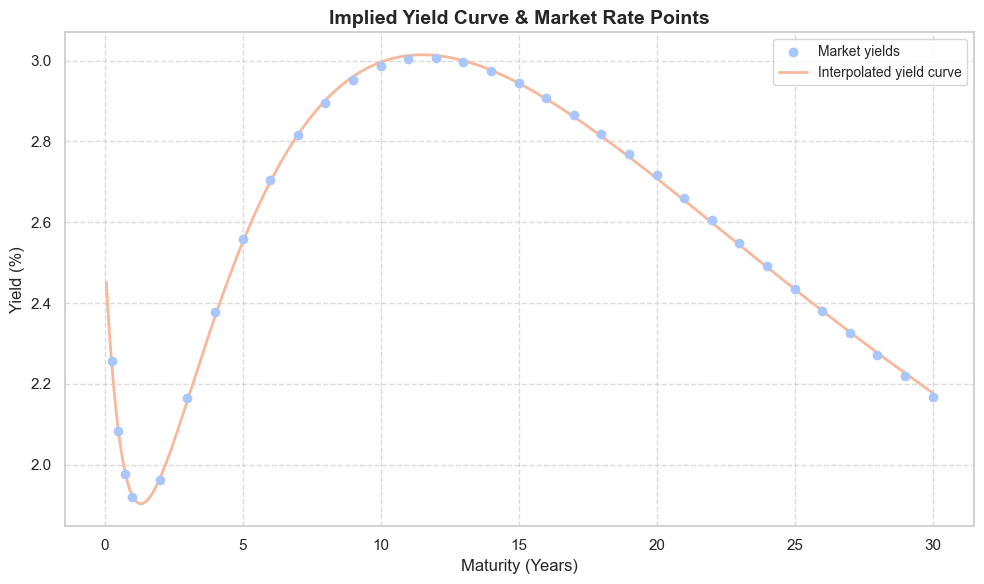

In [13]:
market.rate_curve.display_curve()

#### Visualisation de la surface de volatilité

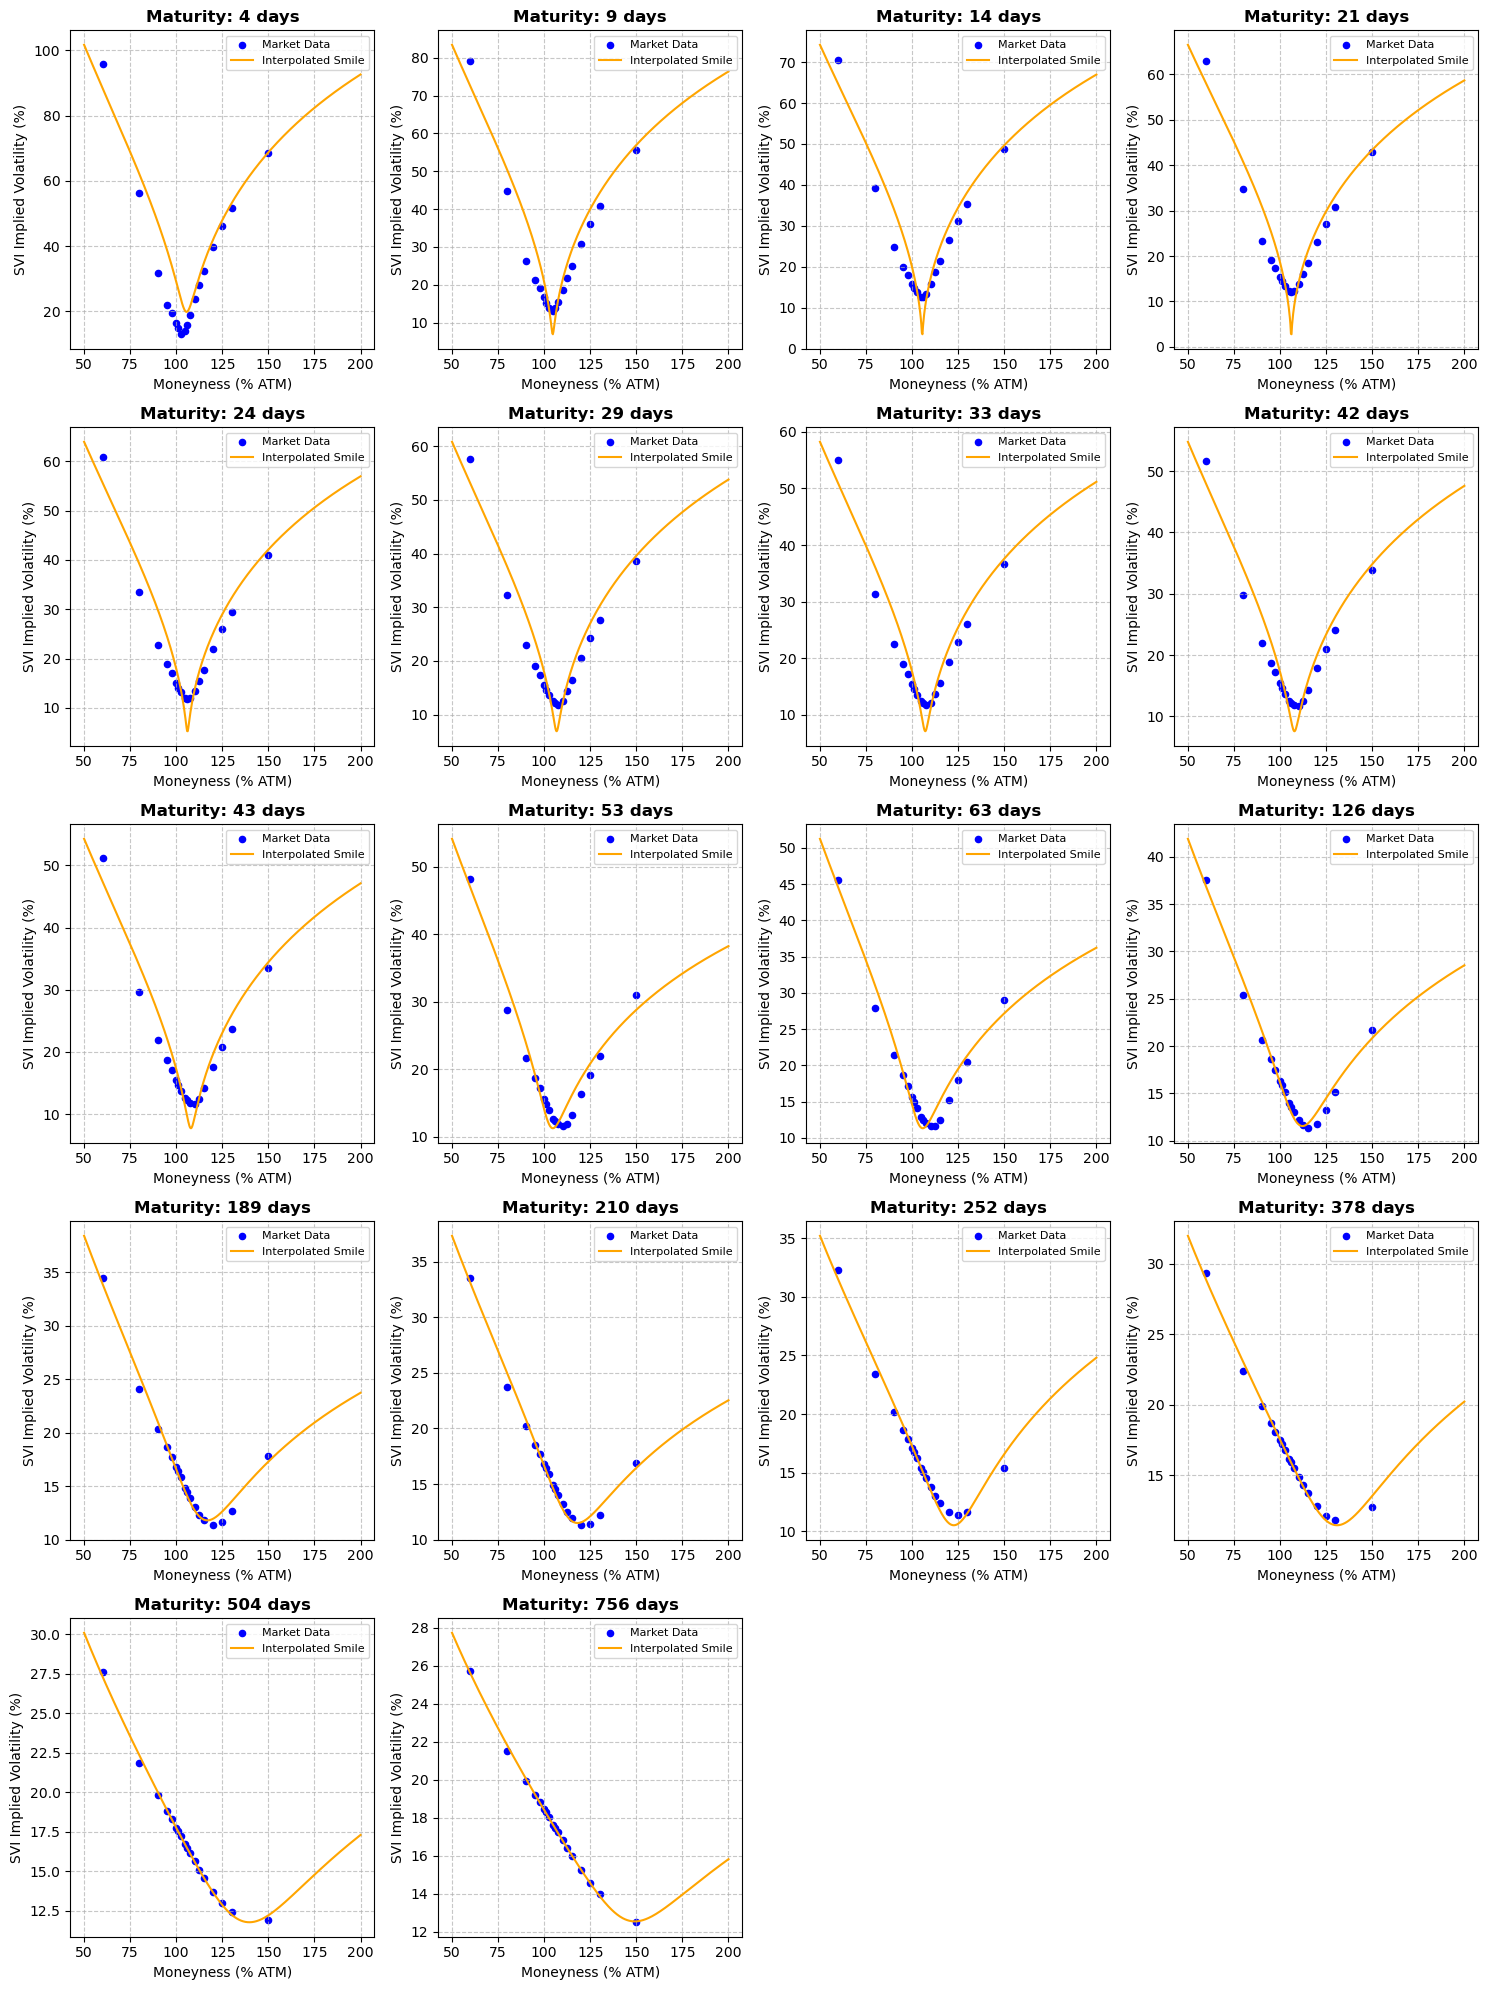

In [20]:
market.volatility_surface.display_smiles()

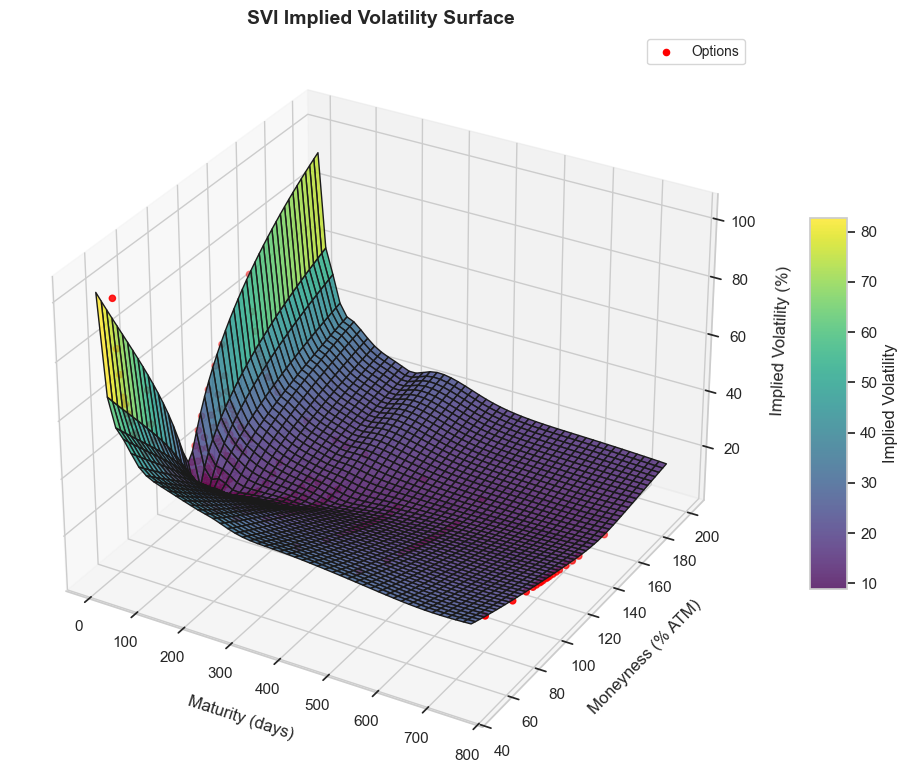

In [15]:
market.volatility_surface.display_surface()